In [1]:
# Imports + InsightLab init
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import insightlab as il
from insightlab.core import CONFIG

import warnings
warnings.filterwarnings("ignore")

# Initialise InsightLab (stakeholder tone + marketing domain)
il.initialize(verbosity="stakeholder", domain="marketing", style=False)
il.load_style(show_banner=False)
il.apply_style()

# Optional: trace metadata (safe if available)
try:
    CONFIG.start_run(
        "Pattern Analysis — Customer Value, Channels & Lifecycle",
        meta={"dataset": "Superstore", "report": "Pattern Analysis", "scope": "No segmentation/clustering"},
    )
except Exception:
    pass



In [2]:
# PATTERN ANALYSIS — Customer Value, Channels & Lifecycle 
il.section("Pattern Analysis — Customer Value, Channels & Lifecycle")

il.box(
    "info",
    "Purpose & scope",
    "This report describes observable customer behaviour patterns to inform CRM planning: customer value, channel preference, "
    "and lifecycle timing (join month, tenure, recency). It is descriptive only (no segmentation/clustering, no predictive modelling). "
    "Timing analysis is limited to join month, tenure, and recency because transaction timestamps are not available."
);

In [3]:
# Load data 
df = pd.read_csv(r"C:\Users\bravo\Portafolio\Dataset\superstore_data.csv")

# Pattern-analysis dataframe (avoid 'seg' naming)
df_pat = df.copy()

# Robust ID column detection
ID_COL = "ID" if "ID" in df_pat.columns else ("Id" if "Id" in df_pat.columns else None)

il.section("Dataset Snapshot")
snapshot = pd.DataFrame({
    "Metric": ["Rows (customers)", "Columns (fields)"],
    "Value": [f"{df_pat.shape[0]:,}", f"{df_pat.shape[1]:,}"],
})
snapshot


,Metric,Value
0,Rows (customers),"2,240"
1,Columns (fields),22


In [4]:
# Time features (cohort, tenure, age) + basic cleaning 
# Convert Dt_Customer to datetime
df_pat["Dt_Customer"] = pd.to_datetime(df_pat["Dt_Customer"], errors="coerce")
ref_date = df_pat["Dt_Customer"].max()

# Tenure (relationship length)
df_pat["Tenure_Days"] = (ref_date - df_pat["Dt_Customer"]).dt.days
df_pat["Tenure_Years"] = df_pat["Tenure_Days"] / 365.25

# Cohort month (join month)
df_pat["Cohort"] = df_pat["Dt_Customer"].dt.to_period("M").astype(str)

# Age (approximate; reference year avoids hard-coded "2025")
df_pat["Year_Birth"] = pd.to_numeric(df_pat["Year_Birth"], errors="coerce")
df_pat["Age"] = ref_date.year - df_pat["Year_Birth"]

# Conservative cleaning (portfolio-safe)
if "Income" in df_pat.columns:
    df_pat["Income"] = pd.to_numeric(df_pat["Income"], errors="coerce")
    df_pat = df_pat[df_pat["Income"].isna() | (df_pat["Income"] < 200000)]

df_pat = df_pat[df_pat["Year_Birth"].isna() | (df_pat["Year_Birth"] > 1920)]
df_pat = df_pat.dropna(subset=["Dt_Customer"])  # essential


In [5]:
# Explain time variables (stakeholder-safe) 
il.section("How to read the time variables in this analysis")

time_explain = """
<h3>How to read the time variables in this analysis</h3>
<p>In this report we use several time-related concepts that look similar but answer different CRM questions.</p>
<ul>
  <li><strong>Cohort (Join Month)</strong>: when the customer joined (join-month wave). Used to compare cohort size and average value <em>at the snapshot date</em>.</li>
  <li><strong>Tenure</strong>: how long the customer has been with us (relationship length). Used to compare behaviour across lifecycle stages (new vs established).</li>
  <li><strong>Recency</strong>: days since last purchase. Used as an operational trigger to prioritise retention and win-back actions.</li>
  <li><strong>Age</strong>: approximate customer age. Used only for light profiling; behaviour (value, channel, activity) remains the primary CRM lever.</li>
</ul>
<p><strong>Important limitation:</strong> Without transaction timestamps, we cannot analyse day-of-week purchasing, time-of-day, or true purchasing seasonality/cadence.</p>
"""
il.show_html(time_explain)

In [6]:
# Value + channel KPIs (RFM-style WITHOUT calling it segmentation)
il.section("Core Behaviour KPIs (Value & Channels)")

# Total spending
spending_cols = ["MntWines", "MntFruits", "MntMeatProducts", "MntFishProducts", "MntSweetProducts", "MntGoldProds"]
for c in spending_cols:
    df_pat[c] = pd.to_numeric(df_pat[c], errors="coerce")
df_pat["Total_Spending"] = df_pat[spending_cols].sum(axis=1, skipna=True)

# Orders by channel (do NOT mix web visits into purchases)
df_pat["Orders_Web"] = pd.to_numeric(df_pat.get("NumWebPurchases"), errors="coerce")
df_pat["Orders_Catalogue"] = pd.to_numeric(df_pat.get("NumCatalogPurchases"), errors="coerce")
df_pat["Orders_Store"] = pd.to_numeric(df_pat.get("NumStorePurchases"), errors="coerce")
df_pat["Total_Orders"] = (df_pat["Orders_Web"] + df_pat["Orders_Catalogue"] + df_pat["Orders_Store"]).fillna(0)

# Separate signals (keep separate, do not add into Total_Orders)
df_pat["Deals_Purchases"] = pd.to_numeric(df_pat.get("NumDealsPurchases"), errors="coerce")
df_pat["Web_Visits_Per_Month"] = pd.to_numeric(df_pat.get("NumWebVisitsMonth"), errors="coerce")

# Channel mix
df_pat["Online_Purchases"] = (df_pat["Orders_Web"] + df_pat["Orders_Catalogue"]).fillna(0)
df_pat["Store_Purchases"] = df_pat["Orders_Store"].fillna(0)

den_orders = df_pat["Total_Orders"].replace(0, np.nan)
df_pat["Online_Share"] = (df_pat["Online_Purchases"] / den_orders).fillna(0.0)
df_pat["Store_Share"] = (df_pat["Store_Purchases"] / den_orders).fillna(0.0)

# Spending shares by category (% of each customer's spending)
den_spend = df_pat["Total_Spending"].replace(0, np.nan)
for col in spending_cols:
    df_pat[f"{col}_Share"] = ((df_pat[col] / den_spend) * 100).fillna(0.0)

# Primary channel label
purchase_cols = ["Orders_Web", "Orders_Catalogue", "Orders_Store"]
df_pat["Primary_Channel"] = df_pat[purchase_cols].idxmax(axis=1).replace(
    {"Orders_Web": "Web", "Orders_Catalogue": "Catalogue", "Orders_Store": "Store"}
)

kpi_tbl = pd.DataFrame({
    "KPI": ["Average Total Spending", "Median Total Spending", "Average Total Orders", "Average Online Share"],
    "Value": [
        f"{df_pat['Total_Spending'].mean():.2f}",
        f"{df_pat['Total_Spending'].median():.2f}",
        f"{df_pat['Total_Orders'].mean():.2f}",
        f"{df_pat['Online_Share'].mean():.2f}",
    ],
})
kpi_tbl


,KPI,Value
0,Average Total Spending,605.99
1,Median Total Spending,396.50
2,Average Total Orders,12.55
3,Average Online Share,0.49


In [7]:
# High-level data quality (stakeholder-friendly) 
il.section("High-level Overview & Data Quality")

missing_cells = int(df_pat.isna().sum().sum())
missing_pct = (missing_cells / (df_pat.shape[0] * df_pat.shape[1])) * 100

pd.DataFrame({
    "Metric": ["Missing cells", "Missing cells (%)"],
    "Value": [f"{missing_cells:,}", f"{missing_pct:.2f}%"],
})

missing_by_field = (df_pat.isna().mean() * 100).sort_values(ascending=False)
missing_tbl = missing_by_field[missing_by_field > 0].head(10).reset_index()
missing_tbl.columns = ["Field", "Missing (%)"]
if len(missing_tbl) > 0:
    il.section("Missing Data (Top Fields)")
    missing_tbl

if ID_COL is not None:
    dup_n = int(df_pat[ID_COL].duplicated().sum())
    pd.DataFrame({"Metric": ["Duplicate customer IDs"], "Value": [f"{dup_n:,}"]})


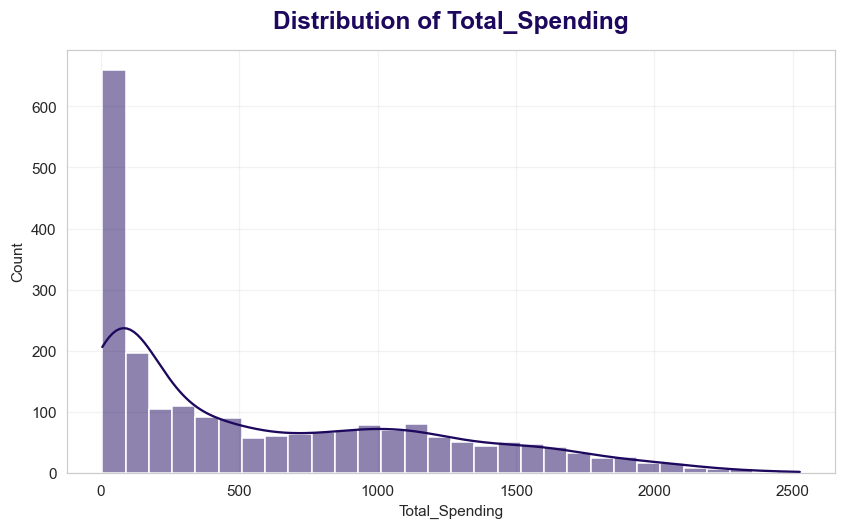

In [8]:
# Baseline Spending Patterns 
il.section("1. Baseline Spending Patterns")

il.box(
    "info",
    "What we are looking at",
    "We start by describing how customer value is distributed (Total Spending) and how it relates to key CRM signals "
    "such as income context and current activity (Recency)."
)

il.plot_distribution(df_pat, col="Total_Spending", report=True)

desc_html = il.story_descriptive(df_pat[["Total_Spending", "Income", "Recency"]].copy())
il.show_html(desc_html)



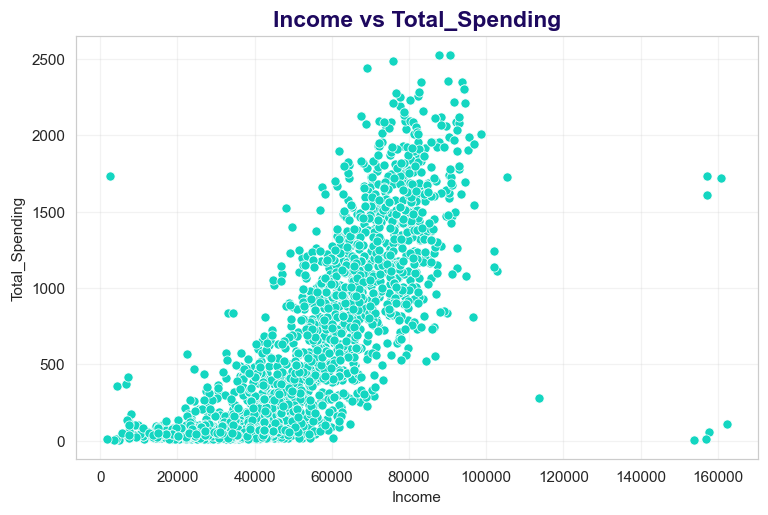

In [9]:
# Income vs Spending (avoid generic auto Insight Summary)
il.section("Income vs Customer Value")

il.plot_scatter(df_pat, x="Income", y="Total_Spending", hue=None, report=False)

il.box(
    "insight",
    "Income vs Customer Value (interpretation)",
    "Income alone is not a reliable proxy for customer value in this dataset. Customers with similar income show "
    "very different spending outcomes, which suggests behaviour and channel preference matter more than demographics "
    "for CRM prioritisation."
);


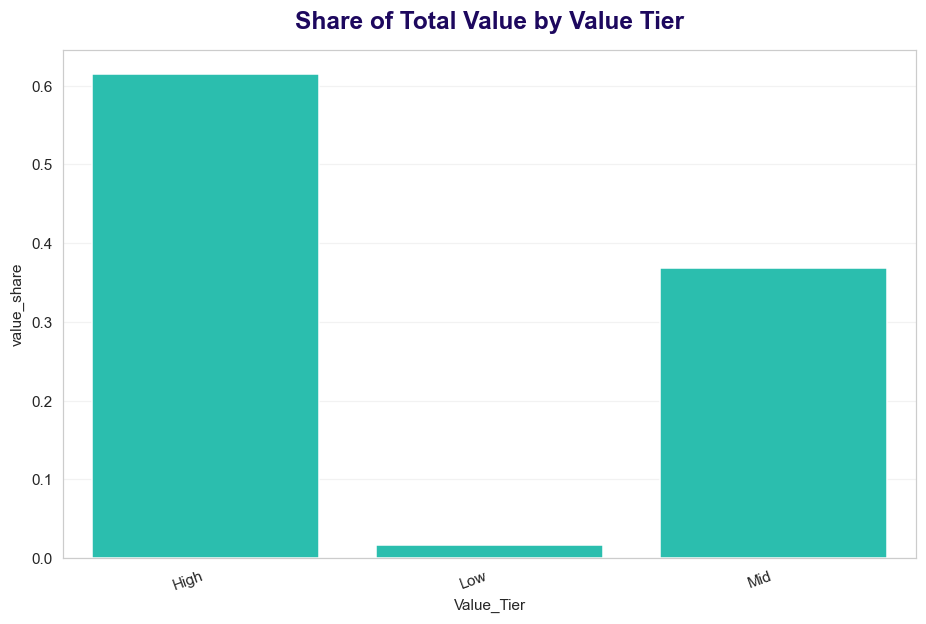

In [10]:
# Value concentration (tiers + Pareto-style table) 
il.section("Value Concentration (Why tiering matters)")

q25, q75 = df_pat["Total_Spending"].quantile([0.25, 0.75]).values

def value_tier(x):
    if pd.isna(x):
        return "Unknown"
    if x <= q25:
        return "Low"
    if x >= q75:
        return "High"
    return "Mid"

df_pat["Value_Tier"] = df_pat["Total_Spending"].apply(value_tier)

tier_tbl = (
    df_pat.groupby("Value_Tier", observed=True)
    .agg(
        customers=(ID_COL if ID_COL else "Total_Spending", "count"),
        avg_spend=("Total_Spending", "mean"),
        median_spend=("Total_Spending", "median"),
        total_value=("Total_Spending", "sum"),
    )
    .reset_index()
)
tier_tbl["customer_share"] = tier_tbl["customers"] / tier_tbl["customers"].sum()
tier_tbl["value_share"] = tier_tbl["total_value"] / tier_tbl["total_value"].sum()
tier_tbl

il.plot_bar(tier_tbl, x="Value_Tier", y="value_share", report=True, title="Share of Total Value by Value Tier")

# Pareto table: top 10% / 20% share of value
tmp = df_pat[["Total_Spending"]].dropna().sort_values("Total_Spending", ascending=False).reset_index(drop=True)
tmp["cum_value_share"] = tmp["Total_Spending"].cumsum() / tmp["Total_Spending"].sum()
n = len(tmp)

def top_share(pct):
    k = int(np.ceil(n * pct))
    return float(tmp.loc[k-1, "cum_value_share"]) if k > 0 else 0.0

pareto = pd.DataFrame({
    "Top % customers": ["Top 10%", "Top 20%"],
    "Share of total value": [top_share(0.10), top_share(0.20)],
})
pareto["Share of total value"] = pareto["Share of total value"].map(lambda x: f"{x:.1%}")
pareto

il.box(
    "business",
    "Business implication",
    "Customer value is typically concentrated. Tiered CRM (service levels, offers, contact strategy) helps protect high-value revenue "
    "while automating efficient journeys for the long tail."
);



In [11]:
# Product spend mix (what categories drive spend) 
il.section("Spending Mix (Product Categories)")

mix_tbl = pd.DataFrame({
    "Category": [c.replace("Mnt", "").replace("Products", "") for c in spending_cols],
    "Average share of spend (%)": [df_pat[f"{c}_Share"].mean() for c in spending_cols],
}).sort_values("Average share of spend (%)", ascending=False)

mix_tbl["Average share of spend (%)"] = mix_tbl["Average share of spend (%)"].map(lambda x: f"{x:.1f}")
mix_tbl

il.box(
    "insight",
    "How to use this",
    "Use the spending mix to prioritise cross-sell and next-best-offer hypotheses. Categories with higher average share are strong "
    "candidates for replenishment journeys and personalised recommendations."
);



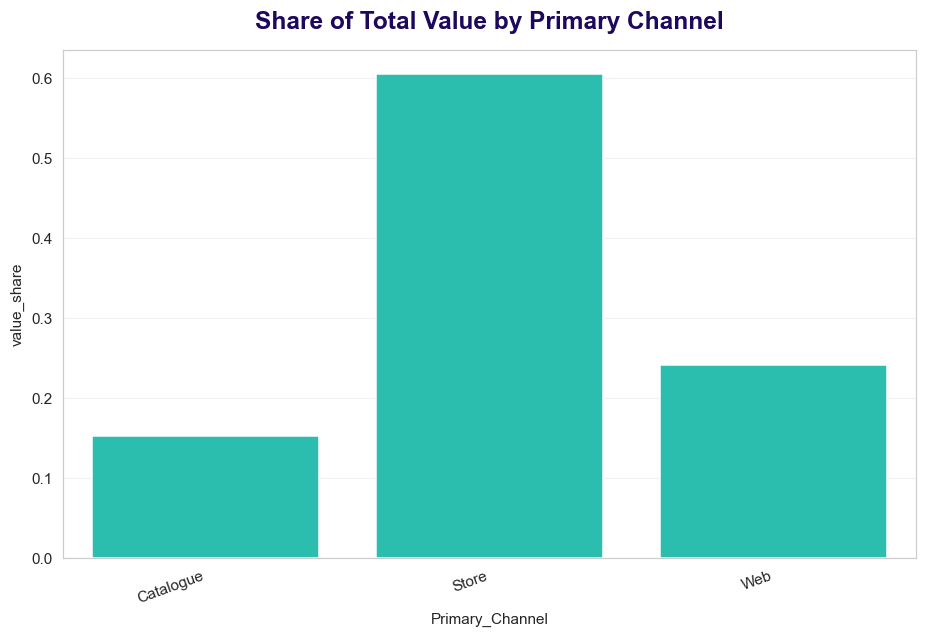

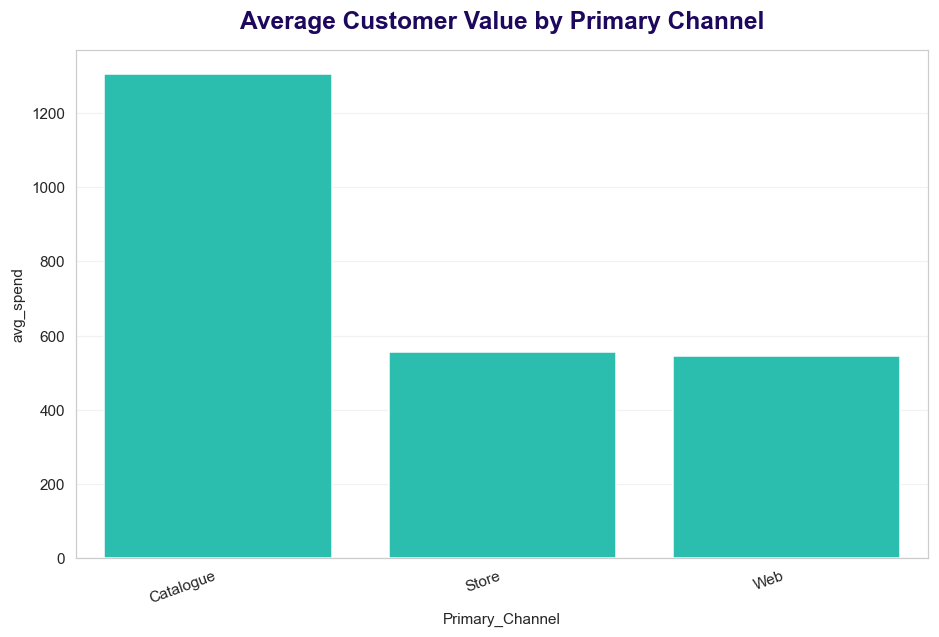

In [12]:
# Channel Behaviour Patterns 
il.section("2. Channel Behaviour Patterns")

chan_tbl = (
    df_pat.groupby("Primary_Channel", observed=True)
    .agg(
        customers=(ID_COL if ID_COL else "Total_Spending", "count"),
        avg_spend=("Total_Spending", "mean"),
        median_spend=("Total_Spending", "median"),
        total_value=("Total_Spending", "sum"),
        avg_online_share=("Online_Share", "mean"),
        avg_web_visits=("Web_Visits_Per_Month", "mean"),
    )
    .reset_index()
)

chan_tbl["customer_share"] = chan_tbl["customers"] / chan_tbl["customers"].sum()
chan_tbl["value_share"] = chan_tbl["total_value"] / chan_tbl["total_value"].sum()
chan_tbl

il.plot_bar(chan_tbl, x="Primary_Channel", y="value_share", report=True, title="Share of Total Value by Primary Channel")
il.plot_bar(chan_tbl, x="Primary_Channel", y="avg_spend", report=True, title="Average Customer Value by Primary Channel")

il.box(
    "business",
    "Business implication",
    "Channel preference is a direct lever for personalisation. Use primary channel and online share to tailor creative, offers, and contact strategy "
    "(store-led retention vs digital-led growth)."
);


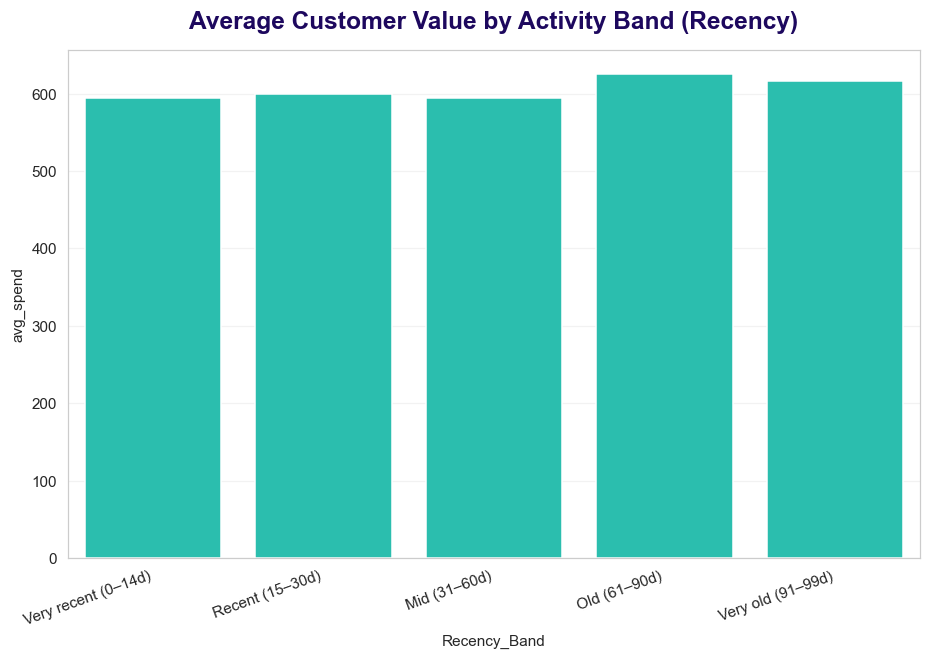

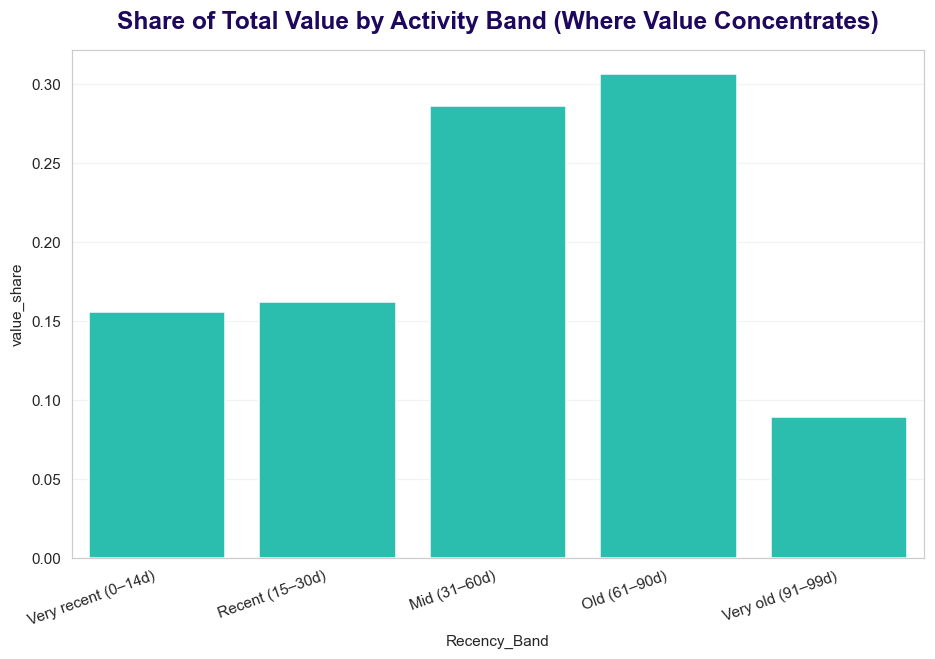

In [13]:
# Lifecycle & Activity Patterns (Recency + Tenure + Cohorts) 
il.section("3. Lifecycle & Activity Patterns")

RECENCY_COL = "Recency"
SPEND_COL = "Total_Spending"

max_r = float(df_pat[RECENCY_COL].max()) if RECENCY_COL in df_pat.columns else 0.0
upper = max(90, int(np.ceil(max_r)))

bins = [-1, 14, 30, 60, 90, upper]
labels = ["Very recent (0–14d)", "Recent (15–30d)", "Mid (31–60d)", "Old (61–90d)", f"Very old (91–{upper}d)"]
df_pat["Recency_Band"] = pd.cut(df_pat[RECENCY_COL], bins=bins, labels=labels)

total_customers = df_pat[ID_COL].notna().sum() if ID_COL else len(df_pat)
total_value = df_pat[SPEND_COL].sum(skipna=True)

rec_profile = (
    df_pat.groupby("Recency_Band", observed=True)
    .agg(
        n_customers=(ID_COL if ID_COL else SPEND_COL, "count"),
        avg_spend=(SPEND_COL, "mean"),
        median_spend=(SPEND_COL, "median"),
        total_value=(SPEND_COL, "sum"),
    )
    .reset_index()
)
rec_profile["customer_share"] = rec_profile["n_customers"] / total_customers
rec_profile["value_share"] = rec_profile["total_value"] / total_value

# CRM treatment map
action_map = {
    "Very recent (0–14d)": "Protect & grow (loyalty, cross-sell, premium service)",
    "Recent (15–30d)": "Nurture (replenishment, personalised recommendations)",
    "Mid (31–60d)": "Prevent churn (incentives, friction reduction, next-best-offer tests)",
    "Old (61–90d)": "Win-back (stronger offer + message testing, channel-appropriate prompts)",
    labels[-1]: "Reactivation or suppress (low-cost repermission, limit frequency)",
}
rec_profile["recommended_action"] = rec_profile["Recency_Band"].astype(str).map(action_map)
rec_profile

il.plot_bar(rec_profile, x="Recency_Band", y="avg_spend", report=True, title="Average Customer Value by Activity Band (Recency)")
il.plot_bar(rec_profile, x="Recency_Band", y="value_share", report=True, title="Share of Total Value by Activity Band (Where Value Concentrates)")

il.box(
    "insight",
    "Interpretation",
    "Recency is an operational priority signal: it indicates who needs action now (retain / win-back), not who is intrinsically ‘worth more’. "
    "The practical output is a set of CRM windows with recommended treatments."
)

# Tenure bands for lifecycle stage
df_pat["Tenure_Band"] = pd.cut(
    df_pat["Tenure_Years"],
    bins=[-0.01, 1, 3, 5, np.inf],
    labels=["New (≤1y)", "Growing (1–3y)", "Mature (3–5y)", "Legacy (5y+)"],
)

il.section("Lifecycle Matrix (Recency × Tenure)")

mat = (
    df_pat.pivot_table(
        index="Tenure_Band",
        columns="Recency_Band",
        values=SPEND_COL,
        aggfunc="sum",
        fill_value=0,
        observed=True,
    )
)
mat_share = mat / mat.values.sum() if mat.values.sum() > 0 else mat
mat_share = mat_share.applymap(lambda x: f"{x:.1%}")
mat_share

il.box(
    "warning",
    "Caveat (timing limits)",
    "This is a customer-level snapshot. Without transaction timestamps we cannot measure day-of-week purchasing or purchase cadence over time. "
    "Timing insights here are limited to join month (cohort), relationship length (tenure), and current activity (recency)."
);

,Cohort,customers,avg_spend,total_value,active_30d,active_60d
0,2012-01,16,894.437500,14311,31.2%,43.8%
1,2012-02,9,779.333333,7014,44.4%,88.9%
2,2012-03,21,519.904762,10918,33.3%,52.4%
3,2012-04,17,637.058824,10830,5.9%,35.3%
4,2012-05,17,801.470588,13625,11.8%,29.4%
5,2012-06,14,569.357143,7971,42.9%,78.6%
6,2012-07,23,661.913043,15224,47.8%,78.3%
7,2012-08,91,708.197802,64446,19.8%,56.0%
8,2012-09,67,948.029851,63518,41.8%,68.7%
9,2012-10,81,680.000000,55080,25.9%,60.5%


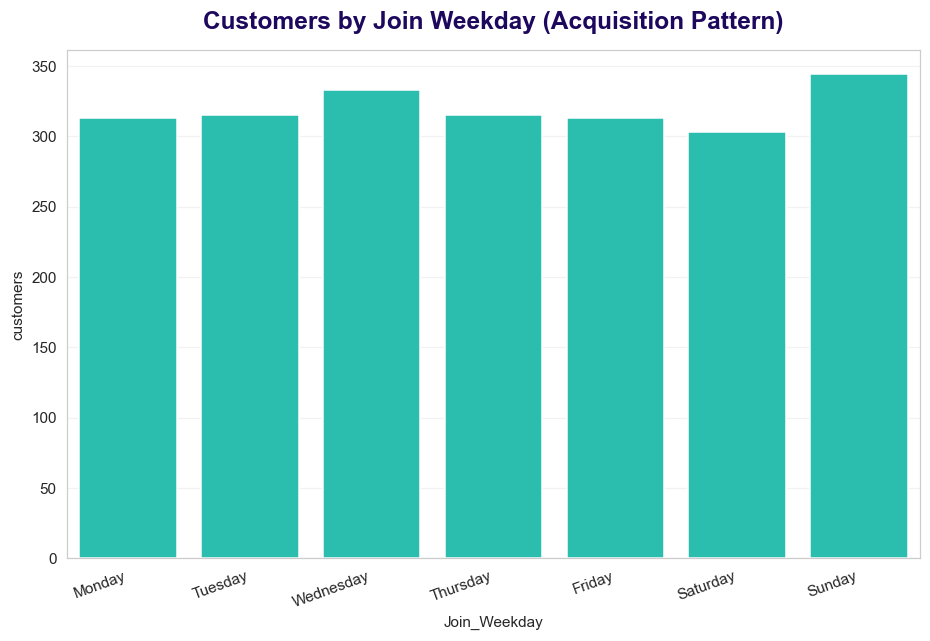

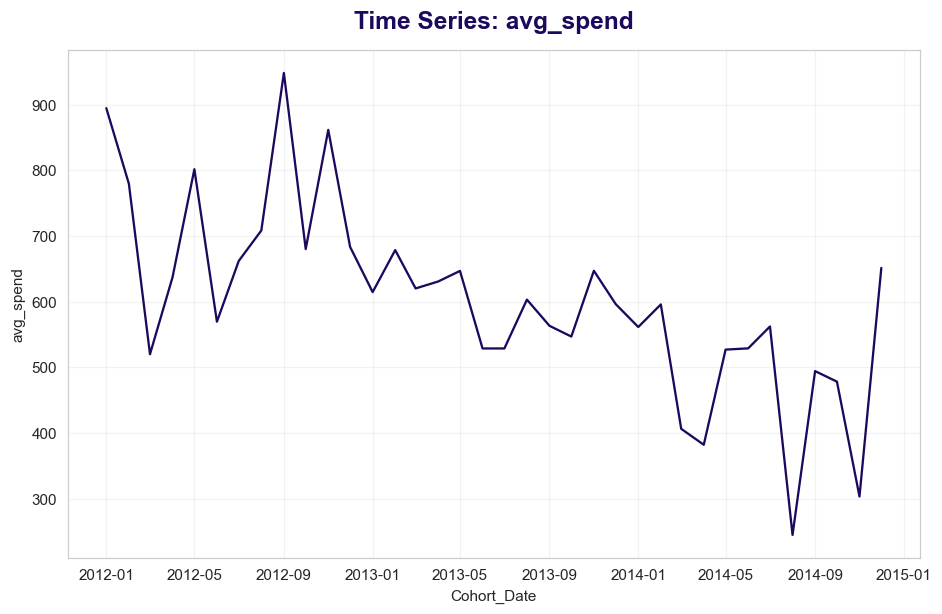

In [14]:
# Cohort Patterns (Join Month) + Join Weekday (Acquisition Timing)

il.section("4. Cohort Patterns (Join Month)")

# Join weekday (acquisition timing, NOT purchase timing)
il.section("Join Weekday (Acquisition Pattern)")

# Day of week from Dt_Customer (join date)
df_pat["Join_Weekday"] = pd.to_datetime(df_pat["Dt_Customer"], errors="coerce").dt.day_name()

join_weekday_tbl = (
    df_pat.groupby("Join_Weekday", observed=True)
    .agg(customers=(ID_COL if ID_COL else SPEND_COL, "count"))
    .reset_index()
)

# Order Monday → Sunday for readability
weekday_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
join_weekday_tbl["Join_Weekday"] = pd.Categorical(join_weekday_tbl["Join_Weekday"], categories=weekday_order, ordered=True)
join_weekday_tbl = join_weekday_tbl.sort_values("Join_Weekday")

join_weekday_tbl

il.box(
    "warning",
    "Important note",
    "This weekday view is based on the customer join date (Dt_Customer). It does not represent day-of-week shopping, "
    "which would require transaction timestamps."
)

# Optional visual (if you want one): customers by join weekday
_ = il.plot_bar(
    join_weekday_tbl,
    x="Join_Weekday",
    y="customers",
    report=True,
    title="Customers by Join Weekday (Acquisition Pattern)"
)

# Cohort spend trend (join-month cohorts)
il.section("Cohort Spending Patterns (Join Month Cohorts)")

cohort_df = (
    df_pat
    .groupby("Cohort", as_index=False)
    .agg(
        avg_spend=("Total_Spending", "mean"),
        n_customers=(ID_COL if ID_COL else SPEND_COL, "count"),
    )
    .sort_values("Cohort")
)

cohort_df["Cohort_Date"] = pd.to_datetime(cohort_df["Cohort"] + "-01", format="%Y-%m-%d", errors="coerce")
cohort_df = cohort_df.dropna(subset=["Cohort_Date"])

# Plot (no 'title' kwarg in your InsightLab plot_time_series)
_ = il.plot_time_series(
    cohort_df,
    time_col="Cohort_Date",
    value_col="avg_spend",
    report=True,
)

# Simple linear trend (descriptive only, not lifecycle-adjusted)
x = cohort_df["Cohort_Date"].dt.year.values.astype(float)
y = cohort_df["avg_spend"].values.astype(float)

if len(cohort_df) >= 2:
    slope, intercept = np.polyfit(x, y, 1)
    direction = "higher" if slope > 0 else ("lower" if slope < 0 else "stable")
    trend_text = (
        f"Across join-month cohorts, average customer value appears {direction} over calendar time (≈ {slope:+.2f} units per year in this descriptive fit). "
        "Important: this comparison is not lifecycle-adjusted — newer cohorts have had less time to accumulate spending, so differences may reflect "
        "time-in-market rather than acquisition quality."
    )
else:
    trend_text = "There are not enough cohorts to estimate a meaningful trend. This view is not lifecycle-adjusted."

il.box(
    "info",
    "How to interpret this cohort view",
    trend_text
)

# Cohort “quality” (activity shares)
il.section("Cohort Quality (Activity at Snapshot Date)")

df_pat["Active_30d"] = df_pat["Recency"].le(30)
df_pat["Active_60d"] = df_pat["Recency"].le(60)

cohort_quality = (
    df_pat.groupby("Cohort", observed=True)
    .agg(
        customers=(ID_COL if ID_COL else SPEND_COL, "count"),
        avg_spend=("Total_Spending", "mean"),
        total_value=("Total_Spending", "sum"),
        active_30d=("Active_30d", "mean"),
        active_60d=("Active_60d", "mean"),
    )
    .reset_index()
    .sort_values("Cohort")
)

cohort_quality["active_30d"] = cohort_quality["active_30d"].map(lambda v: f"{v:.1%}")
cohort_quality["active_60d"] = cohort_quality["active_60d"].map(lambda v: f"{v:.1%}")

cohort_quality


Primary_Channel,Catalogue,Store,Web
Join_Weekday,,,
Monday,13.8%,13.6%,15.0%
Tuesday,13.8%,14.6%,12.8%
Wednesday,17.6%,13.8%,16.8%
Thursday,9.4%,14.2%,15.2%
Friday,13.8%,14.1%,13.8%
Saturday,17.0%,13.2%,13.5%
Sunday,14.5%,16.5%,12.8%


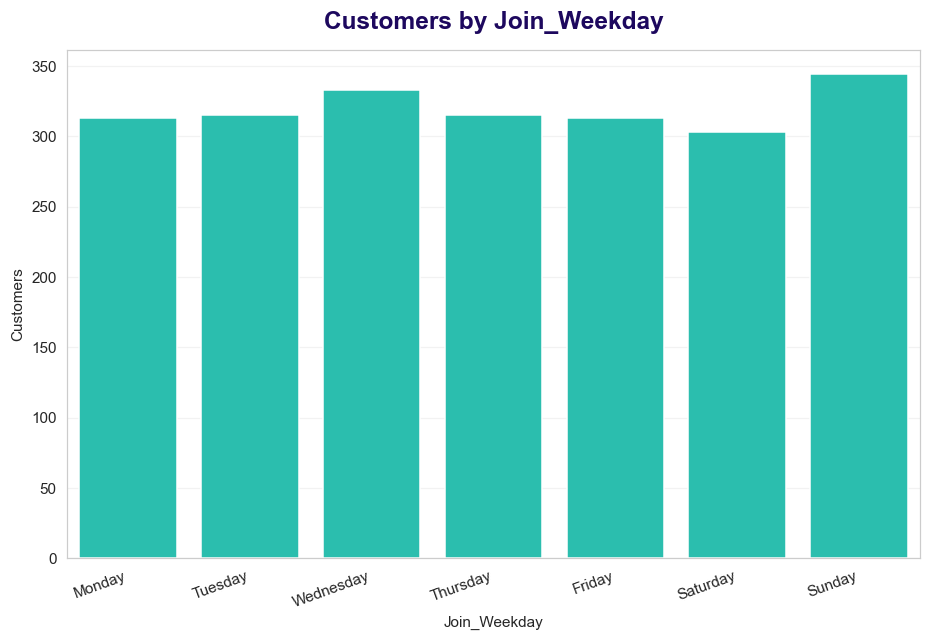

In [15]:
# Join Weekday Patterns by Channel / Platform (Acquisition timing, NOT shopping)

il.section("Join Weekday Patterns by Channel (Acquisition Timing)")

# Ensure join weekday exists
df_pat["Join_Weekday"] = pd.to_datetime(df_pat["Dt_Customer"], errors="coerce").dt.day_name()

# Ensure Primary_Channel exists (Web / Catalogue / Store)
# (If you already created it earlier, you can skip this block)
purchase_cols = ["Orders_Web", "Orders_Catalogue", "Orders_Store"]
if "Primary_Channel" not in df_pat.columns and all(c in df_pat.columns for c in purchase_cols):
    df_pat["Primary_Channel"] = df_pat[purchase_cols].idxmax(axis=1).replace(
        {"Orders_Web": "Web", "Orders_Catalogue": "Catalogue", "Orders_Store": "Store"}
    )

weekday_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
df_pat["Join_Weekday"] = pd.Categorical(df_pat["Join_Weekday"], categories=weekday_order, ordered=True)

# Table: weekday × primary channel
join_day_channel = (
    df_pat.groupby(["Join_Weekday", "Primary_Channel"], observed=True)
    .size()
    .reset_index(name="Customers")
)

# Optional: share within each channel (so you compare shapes, not only volume)
join_day_channel["Share_within_channel"] = (
    join_day_channel["Customers"]
    / join_day_channel.groupby("Primary_Channel")["Customers"].transform("sum")
)

join_day_channel.sort_values(["Primary_Channel", "Join_Weekday"])

il.box(
    "warning",
    "Important note",
    "This analysis uses the customer join date (Dt_Customer). It shows acquisition timing by weekday and channel preference. "
    "It does not represent shopping weekday patterns, which require transaction timestamps."
)

# Visual 1: Volume by weekday (overall)
overall_join = (
    df_pat.groupby("Join_Weekday", observed=True)
    .size()
    .reset_index(name="Customers")
    .sort_values("Join_Weekday")
)

il.section("Overall Join Volume by Weekday")
_ = il.plot_bar(overall_join, x="Join_Weekday", y="Customers", report=True)

# Visual 2: Share by weekday within each channel (table is usually sufficient)
il.section("Join Weekday Share within Each Channel (Shape Comparison)")
join_day_channel_pivot = join_day_channel.pivot_table(
    index="Join_Weekday",
    columns="Primary_Channel",
    values="Share_within_channel",
    aggfunc="sum",
    fill_value=0,
    observed=True,
)
join_day_channel_pivot = join_day_channel_pivot.applymap(lambda v: f"{v:.1%}")
join_day_channel_pivot


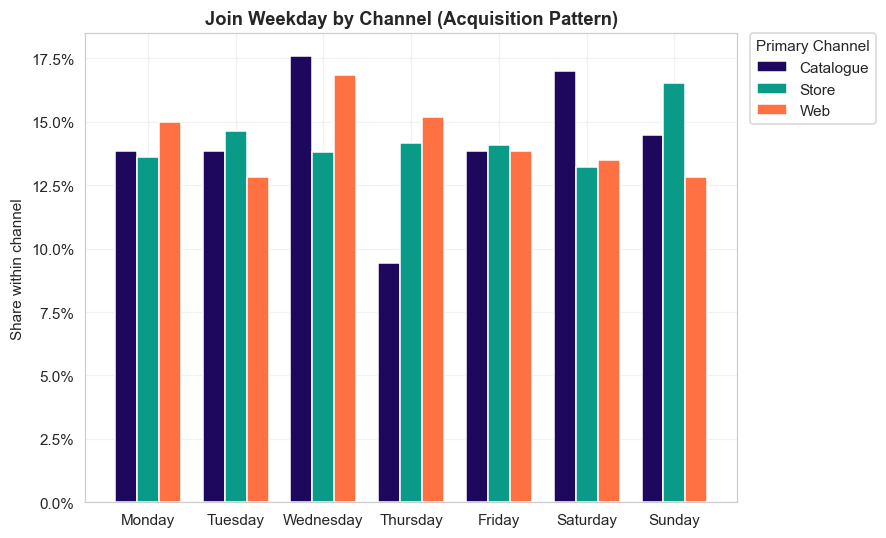

In [16]:
# Ensure weekday order
weekday_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

df_pat["Join_Weekday"] = pd.to_datetime(df_pat["Dt_Customer"], errors="coerce").dt.day_name()
df_pat["Join_Weekday"] = pd.Categorical(df_pat["Join_Weekday"], categories=weekday_order, ordered=True)

purchase_cols = ["Orders_Web", "Orders_Catalogue", "Orders_Store"]
if "Primary_Channel" not in df_pat.columns and all(c in df_pat.columns for c in purchase_cols):
    df_pat["Primary_Channel"] = df_pat[purchase_cols].idxmax(axis=1).replace(
        {"Orders_Web": "Web", "Orders_Catalogue": "Catalogue", "Orders_Store": "Store"}
    )

join_day_channel = (
    df_pat.dropna(subset=["Join_Weekday", "Primary_Channel"])
    .groupby(["Join_Weekday", "Primary_Channel"], observed=True)
    .size()
    .reset_index(name="Customers")
)

join_day_channel["Share_within_channel"] = (
    join_day_channel["Customers"]
    / join_day_channel.groupby("Primary_Channel")["Customers"].transform("sum")
)

pivot = join_day_channel.pivot_table(
    index="Join_Weekday",
    columns="Primary_Channel",
    values="Share_within_channel",
    aggfunc="sum",
    fill_value=0,
    observed=True,
).reindex(weekday_order)

channel_order = ["Catalogue", "Store", "Web"]
for c in channel_order:
    if c not in pivot.columns:
        pivot[c] = 0.0
pivot = pivot[channel_order]

x = np.arange(len(pivot.index))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 5))

for i, ch in enumerate(channel_order):
    ax.bar(x + (i - 1) * width, pivot[ch].values, width, label=ch)

ax.set_xticks(x)
ax.set_xticklabels(pivot.index)
ax.yaxis.set_major_formatter(PercentFormatter(1.0))
ax.set_ylabel("Share within channel")
ax.set_title("Join Weekday by Channel (Acquisition Pattern)")

# --- Move legend outside (right side) ---
ax.legend(
    title="Primary Channel",
    loc="upper left",
    bbox_to_anchor=(1.02, 1.0),
    borderaxespad=0
)

# --- Make room on the right for the legend ---
plt.tight_layout(rect=[0, 0, 0.82, 1])

plt.show()

In [17]:
# action plan 
il.section("5. Recommended CRM Actions (Based on Patterns)")

actions = [
    ("Value tiering", "Define Low/Mid/High tiers from Total Spending and align service levels and offers."),
    ("Channel personalisation", "Tailor journeys by Primary Channel and Online Share (creative + offer + contact strategy)."),
    ("Lifecycle triggers", "Deploy automated triggers by Recency band (protect / nurture / prevent churn / win-back)."),
    ("Test & measure", "Run A/B tests on message, offer, and channel strategy; track repeat rate, reactivation, and revenue protected."),
]
pd.DataFrame(actions, columns=["Workstream", "What to do next"])

il.box(
    "info",
    "Final note on credibility",
    "All timing insights in this report are based on join date (cohort), relationship length (tenure), and current activity (recency). "
    "Day-of-week and time-of-day purchasing patterns require transaction timestamps and are intentionally excluded here."
);

In [18]:
il.export_notebook(
    input_path="PATTERN_ANALYSIS.ipynb",
    output_path="Pattern_Analysis_report.html",
    title="Pattern_Analysis",
    execute=False,  # ← Changed to True
);